<a href="https://colab.research.google.com/github/erezimm/ML-ML/blob/master/DeepSet_red.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main notebook, to be run on Google Colab

## Import dependencies and download dataset

In [1]:
!pip install dgl

import glob
import os
import shutil
from datetime import datetime

import astropy.io.ascii
import dgl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

if not torch.cuda.is_available():
    raise Exception('Cuda unavailable, turn it on under Runtime>Change runtime type>GPU')
device = torch.device('cuda')

training_path = '/content/training_set'
validation_path = '/content/validation_set'
for path in (training_path, validation_path):
    if not os.path.isdir(path):
        os.makedirs(path)

!wget -O data.zip https://www.dropbox.com/s/w8dpzhfsz5odau4/data_r.zip?dl=0
!unzip -o -q data.zip -d /content/
data_path = '/content/data_r'
microlist = glob.glob(data_path+'/microlensedconst_*')
varlist = glob.glob(data_path+'/cleanvar_*')
for typelist in (microlist, varlist):
    for i, f in enumerate(typelist):
        dest = training_path if i<len(microlist)/2 else validation_path
        shutil.move(f, os.path.join(dest, os.path.basename(f)))

     |████████████████████████████████| 3.0MB 2.8MB/s 


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
--2020-08-18 18:01:15--  https://www.dropbox.com/s/w8dpzhfsz5odau4/data_r.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.1, 2620:100:601d:1::a27d:501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/w8dpzhfsz5odau4/data_r.zip [following]
--2020-08-18 18:01:16--  https://www.dropbox.com/s/raw/w8dpzhfsz5odau4/data_r.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca471f1b2cd021ce32fc00c07f3.dl.dropboxusercontent.com/cd/0/inline/A9tU4AmkrzpeH4FmB7SR_WM3DybV0QBT2bQ7rn1fjUs8V9PmffNdrLoSYZOtcnGRZDrHCTRp-kN4doLRLV8LaCa9td4pLLgva2pfUgevPEkVMYImq9TLgDrOw20B8ZDYKVY/file# [following]
--2020-08-18 1

## Create Datasets
Class CustomDataset loads all files and converts them to a list of graphs.
Each node in a graph is a data point, i.e. node features are days since start, mag, magerr

In [16]:
class CustomDataset(Dataset):
    def __init__(self, path, allTrue=False):
        filelist = glob.glob(path+'/*')
        
        self.graphs = []
        self.isMicrolensed = []
        for fname in tqdm(filelist):
            filebasename = os.path.basename(fname)
            if allTrue:
                microlensed = torch.tensor([1])
            elif filebasename.startswith('cleanvar'):
                microlensed = torch.tensor([0])
            elif filebasename.startswith('microlensedconst'):
                microlensed = torch.tensor([1])
            else:
                raise Exception('Filename ' + fname + ' not clean_* or microlensed_*')
            
            with open(fname) as f:
                data = astropy.io.ascii.read(f.read())
                times, mags, magerrs = data['col1'], [], data['col3']
                for m, err in zip(data['col2'], magerrs):
                    mags.append(round(m, len(str(err).split('.')[1])))
                zipped = list(zip(times, mags, magerrs))
                zipped.sort(key=lambda tup: tup[0])
                times, mags, magerrs = zip(*zipped)
                times, mags, magerrs =torch.tensor(times), torch.tensor(mags), torch.tensor(magerrs)
                
                times = times - min(times)
                flux = 10 ** (mags/(-2.5))
                medflux = torch.median(flux)
                flux = flux/medflux
                fluxerr = flux * magerrs * np.log(10) * 0.4 / medflux

                n = len(times)
                g = dgl.DGLGraph()
                g.add_nodes(n)
                g.ndata['time'] = torch.tensor(times).float()  # days
                g.ndata['mag'] = torch.tensor(flux).float()
                g.ndata['magerr'] = torch.tensor(fluxerr).float()


                #g.add_edges([i for i in range(n)], [(i+1)%n for i in range(n)])
                #g.add_edges([i for i in range(n)], [(i-1)%n for i in range(n)])
                
                self.graphs.append(g)
                self.isMicrolensed.append(microlensed)
        
    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx], self.isMicrolensed[idx]



In [ ]:

train_ds = CustomDataset(training_path)
validation_ds = CustomDataset(validation_path)

nx.draw(dgl.to_networkx(train_ds[20][0]))

In [4]:
def collate(samples):
    # The input `samples` is a list, a batch of whatever comes out of your dataset object
    graphs = [x[0] for x in samples]
    labels = [x[1] for x in samples]
    
    batched_graph = dgl.batch(graphs, node_attrs=['time', 'mag', 'magerr'])
    targets = torch.cat(labels)
    
    return batched_graph, targets.unsqueeze(1).float()

## The Network

In [5]:
layers = [10,10]  # hidden layers in the DeepSetLayer
outputsize = 7  # length of the representation passed to the final network
cllayers = [10,5,5]  # hidden layers in the final network (takes outputsize, returns a scalar which is the classification)

In [6]:
def build_layers(inp,out,sizes):
    sizes = [inp]+sizes+[out]
    layers = []
    for i in range(len(sizes)-1):
        layers.extend([nn.Linear(sizes[i], sizes[i+1]), nn.LeakyReLU()])
    
    return layers

In [7]:
# #Deep Set

class DeepSet(nn.Module):

    def __init__(self, config):
        super(DeepSet, self).__init__()

        self.config = config

        self.layers = nn.ModuleList()

        self.layers.append(DeepSetLayer(config['inputsize'], config['layers'][0], config['inputs'], config['output'] ))

        n_layers = len(config['layers'])

        for i in range(n_layers - 1):

            self.layers.append(DeepSetLayer(config['inputsize']+ config['layers'][i],
                                            config['layers'][i+1], 
                                            config['inputs'] + [config['output']], 
                                            config['output']))
            

        self.layers.append(DeepSetLayer(config['inputsize']+ config['layers'][-1],
                                            config['outputsize'], 
                                            config['inputs'] + [config['output']],
                                            config['output']))  

        layers = build_layers(config['outputsize'], 2, config['cllayers'])  # OFEK chnaged to output=2
        self.classifier = nn.Sequential(*(layers+ [nn.Softmax()]))  # OFEK added SoftMax
    
    def forward(self, g):

        for layer in self.layers:
            
            g = layer(g) 

        mean_nodes= dgl.mean_nodes(g, 'node_embed', weight = None)
        output = self.classifier(mean_nodes)


        return output 


In [8]:
class DeepSetLayer(nn.Module):
    def __init__(self, inputsize, outputsize, inputnames, outputname):
        


        super(DeepSetLayer,self).__init__()

        self.inputs      = inputnames
        self.outputname = outputname


  

        layers = build_layers(inputsize, outputsize, [int(0.5*(outputsize + inputsize)   )])

        self.node_embedd = nn.Sequential(*layers)

        layers = build_layers(outputsize + inputsize, outputsize,[ int( 0.5*(outputsize + inputsize)) ] )

        self.node_update = nn.Sequential(*layers)



    def forward(self, g):

        gn = [g.ndata[inputname] for inputname in self.inputs]
        unsqdim = max(max([len(n.shape) for n in gn]),2)
        tocat = []
        for n in gn:
            t = n
            for _ in range(unsqdim-len(n.shape)):
                t = t.unsqueeze(-1)
            tocat.append(t)
            # print(t.shape)
        node_data = torch.cat(tocat, dim=1)

        g.ndata['node_embed'] = self.node_embedd(node_data)


        node_sum = dgl.mean_nodes(g, 'node_embed', weight = None)  #Global representation of graph 

        g.ndata['mean_nodes'] = dgl.broadcast_nodes(g, node_sum)
        
        

        gn = [g.ndata[inputname] for inputname in self.inputs] + [g.ndata['mean_nodes']]
        unsqdim = max(max([len(n.shape) for n in gn]),2)
        tocat = []
        for n in gn:
            t = n
            for _ in range(unsqdim-len(n.shape)):
                t = t.unsqueeze(-1)
            tocat.append(t)
            # print(t.shape)
        node_update_input = torch.cat( tocat, dim=1  )

        g.ndata[self.outputname] = self.node_update(node_update_input)


        return g #contains global information 


In [9]:
net = DeepSet({'inputsize':3 , 'outputsize':outputsize, 'inputs':['time', 'mag', 'magerr'], 'output':'finalrep', 'layers':layers, 'cllayers':cllayers})
net.to(device)

DeepSet(
  (layers): ModuleList(
    (0): DeepSetLayer(
      (node_embedd): Sequential(
        (0): Linear(in_features=3, out_features=6, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=6, out_features=10, bias=True)
        (3): LeakyReLU(negative_slope=0.01)
      )
      (node_update): Sequential(
        (0): Linear(in_features=13, out_features=6, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=6, out_features=10, bias=True)
        (3): LeakyReLU(negative_slope=0.01)
      )
    )
    (1): DeepSetLayer(
      (node_embedd): Sequential(
        (0): Linear(in_features=13, out_features=11, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=11, out_features=10, bias=True)
        (3): LeakyReLU(negative_slope=0.01)
      )
      (node_update): Sequential(
        (0): Linear(in_features=23, out_features=11, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        

## Train

In [19]:
def evaluate(net, validation_ds, allTrue=False):
    test_data_loader = DataLoader(validation_ds, batch_size=1000, shuffle=True, collate_fn=collate)

    net.cpu()
    net.eval()

    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    total_positives = 0
    total_negatives = 0

    for i, (x,y) in enumerate(test_data_loader):
            y = y.data.numpy()
            y = y.transpose()
            prediction = net(x).cpu().data.numpy()
            pred = (prediction[:,1]>prediction[:,0])
            
            total_positives+=len(np.where( y==1 )[0])
            total_negatives+=len(np.where( y==0 )[0])
            

            true_positive+= len(np.where( (pred==1) & (y==1) )[0])
            false_positive+= len(np.where( (pred==1) & (y==0) )[0])
    # print(pred, prediction, y)
    print('Probability of detection:', true_positive/total_positives)  # probability of recognizing a microlensing when you see it
    if not allTrue:
        print('Probability of false alarm:', false_positive/total_negatives)  # probability for misclassification of a variable star as microlensing

In [11]:
# options:
# loss_func = nn.BCEWithLogitsLoss()
# loss_func = nn.L1Loss()
loss_func = nn.CrossEntropyLoss()
#optimizer = optim.Adadelta(net.parameters(), lr=1)
#optimizer = optim.SGD(net.parameters(), lr=0.01)
optimizer = optim.Adam(net.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

n_epochs = 100


losses = []
epoch_valid_loss=[]

data_loader = DataLoader(train_ds, batch_size=1000, shuffle=True, collate_fn=collate)
valid_dl = DataLoader(train_ds, batch_size=1000, shuffle=True, collate_fn=collate)
for epoch in tqdm(range(n_epochs)):
    net.train()
    this_losses = []
    for x,y in data_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = net(x)
        # print(output)
        # output = torch.cat((1-output, output), dim=1)
        # print(output)
        loss = loss_func(output.squeeze(), y.long().squeeze())
        this_losses.append(float(loss))
        loss.backward()
        optimizer.step()
    
    losses.append(np.mean(this_losses))

    net.eval()
    this_losses = []
    for x,y in valid_dl:

        x = x.to(device)
        y = y.to(device)
        pred = net(x)
        valid_loss = loss_func(pred.squeeze(),y.long().squeeze())
        this_losses.append(float(valid_loss))

    epoch_valid_loss.append(np.mean(this_losses))

    
    print('Epoch:', epoch, 'trainloss:', round(losses[-1], 4), 'validloss:', round(epoch_valid_loss[-1],4))  # for some real-time indication (couldn't manage to get this to dynamically plot)


# losses = []

# data_loader = DataLoader(train_ds, batch_size=1000, shuffle=True, collate_fn=collate)
# for epoch in tqdm(range(n_epochs)):
#     net.train()
#     this_losses = []
#     for x,y in data_loader:
#         x, y = x.to(device), y.to(device)
#         optimizer.zero_grad()
#         output = net(x)
#         # print(output)
#         # output = torch.cat((1-output, output), dim=1)
#         # print(output)
#         loss = loss_func(output.squeeze(), y.long().squeeze())
#         this_losses.append(float(loss))
#         loss.backward()
#         optimizer.step()

#     losses.append(np.mean(this_losses))
#     print('Epoch:', epoch, 'Loss:', round(losses[-1], 4))  # for some real-time indication (couldn't manage to get this to dynamically plot)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 0 trainloss: 0.66 validloss: 0.6464
Epoch: 1 trainloss: 0.6467 validloss: 0.6467
Epoch: 2 trainloss: 0.6466 validloss: 0.6465
Epoch: 3 trainloss: 0.6466 validloss: 0.6464
Epoch: 4 trainloss: 0.6466 validloss: 0.6465
Epoch: 5 trainloss: 0.6465 validloss: 0.6463
Epoch: 6 trainloss: 0.6463 validloss: 0.6463
Epoch: 7 trainloss: 0.6463 validloss: 0.6463
Epoch: 8 trainloss: 0.6464 validloss: 0.6463
Epoch: 9 trainloss: 0.6463 validloss: 0.6463
Epoch: 10 trainloss: 0.6464 validloss: 0.6467
Epoch: 11 trainloss: 0.6468 validloss: 0.6464
Epoch: 12 trainloss: 0.6462 validloss: 0.6462
Epoch: 13 trainloss: 0.6463 validloss: 0.6462
Epoch: 14 trainloss: 0.6463 validloss: 0.6464
Epoch: 15 trainloss: 0.6465 validloss: 0.6461
Epoch: 16 trainloss: 0.6461 validloss: 0.6461
Epoch: 17 trainloss: 0.6462 validloss: 0.6461
Epoch: 18 trainloss: 0.6461 validloss: 0.6459
Epoch: 19 trainloss: 0.6458 validloss: 0.6456
Epoch: 20 trainloss: 0.6454 validloss: 0.645
Epoch: 21 trainloss: 0.6446 validloss: 0.6434
E

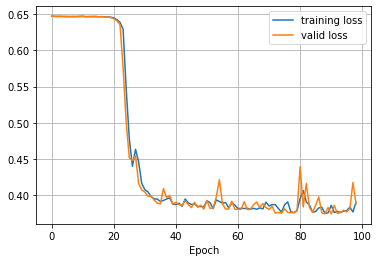

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Probability of detection: 0.9573613126465007
Probability of false alarm: 0.10949882799419577


In [12]:
  # plot the printed losses:
losses = np.array(losses)
plt.plot(losses[1:],label='training loss')
plt.plot(epoch_valid_loss[1:],label='valid loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

evaluate(net, validation_ds)  # show P_D, P_FA TODO: CHANGE SU IT RUNS

## Save
Don't forget to download

In [13]:
timestamp = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
torch.save(net.state_dict(), 'model_' + timestamp + '.pt')

--2020-08-18 18:29:59--  https://github.com/erezimm/ML-ML/raw/master/confirmed_microlensing.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/erezimm/ML-ML/master/confirmed_microlensing.zip [following]
--2020-08-18 18:29:59--  https://raw.githubusercontent.com/erezimm/ML-ML/master/confirmed_microlensing.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29720 (29K) [application/zip]
Saving to: ‘/content/confirmed_microlensing.zip’

/content/confirmed_ 100%[===================>]  29.02K  --.-KB/s    in 0.01s   

2020-08-18 18:29:59 (2.18 MB/s) - ‘/content/confirmed_microlensing.zip’ saved [29720/29

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input


Probability of detection: 0.8421052631578947


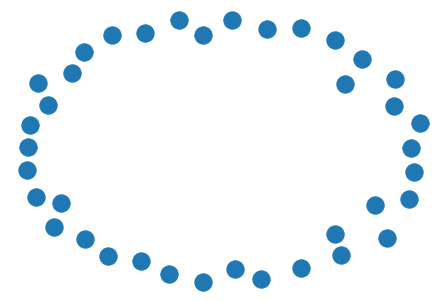

In [26]:
!wget -O /content/confirmed_microlensing.zip https://github.com/erezimm/ML-ML/raw/master/confirmed_microlensing.zip
!unzip -o -q confirmed_microlensing.zip  -d /content/
!mkdir -p /content/confirmed_microlensing/r /content/confirmed_microlensing/g
!mv /content/confirmed_microlensing/*_r /content/confirmed_microlensing/r
!mv /content/confirmed_microlensing/*_g /content/confirmed_microlensing/g

data_path = '/content/confirmed_microlensing'
rpath = data_path+'/r'
gpath = data_path+'/g'
# os.system('mkdir -p '+rpath+' '+gpath)

# for f in glob.glob(data_path):
#     if f.endswith('_r'):
#         shutil.move(f, rpath)
#     elif f.endswith('_g'):
#         shutil.move(f, gpath)
#     else:
#         print(f)

conf_ds = CustomDataset(gpath, allTrue=True)
# print(len(conf_ds))
nx.draw(dgl.to_networkx(conf_ds[2][0]))


evaluate(net, conf_ds, allTrue=True)